## Plotting GC results across multiple nodes

Length of files:  8


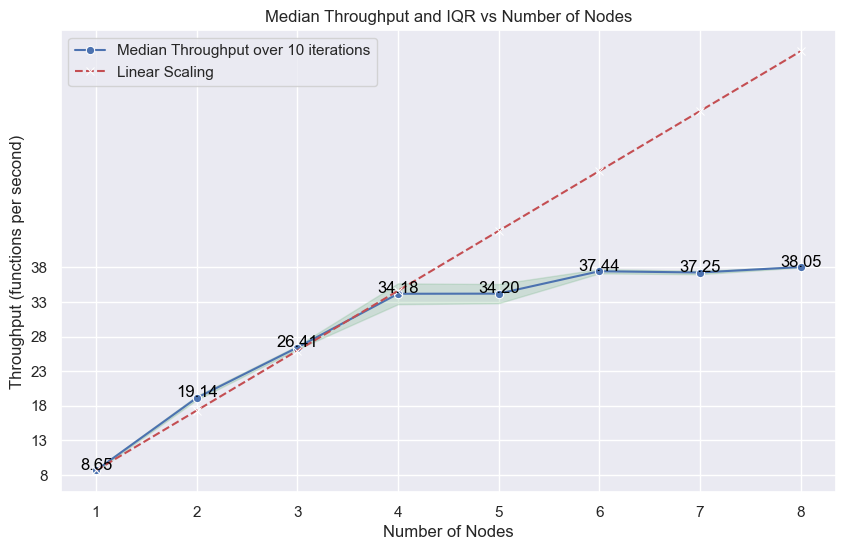

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_globus-torch.json where # is the number of nodes.
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_globus-torch.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2]=='throughput' and file.split('_')[3]=='pytorch' and file.split('_')[4]=='concurrent' and file.split('_')[5]=='1024' and file.split('_')[6]=='globus-torch.json']
print("Length of files: ", len(files))
data_list = []

for file in files:
    with open(os.path.join(file_dir, file), 'r') as f:
        data = json.load(f)
        # Extract the number of nodes from the filename
        nodes = int(file.split('_')[0])
        throughputs = [data[key]['throughput'] for key in data]
        median_throughput = np.median(throughputs)
        q75, q25 = np.percentile(throughputs, [75, 25])
        iqr = q75 - q25
        
        data_list.append({
            'Nodes': nodes,
            'Median Throughput': median_throughput,
            'IQR': iqr
        })

# Convert data_list to a DataFrame
df = pd.DataFrame(data_list)

# Sort the DataFrame by the number of nodes
df = df.sort_values(by='Nodes')

# Calculate the theoretical scaling line
initial_throughput = df[df['Nodes'] == 1]['Median Throughput'].values[0]
df['Linear Scaling'] = df['Nodes'] * initial_throughput

# Create a Seaborn plot
plt.figure(figsize=(10, 6))

sns.set_theme(style="darkgrid")

# Plot the median throughput
sns.lineplot(data=df, x='Nodes', y='Median Throughput', marker='o', label='Median Throughput over 10 iterations')

# Add the fill between for IQR
plt.fill_between(df['Nodes'], 
                 df['Median Throughput'] - df['IQR'] / 2, 
                 df['Median Throughput'] + df['IQR'] / 2, 
                 color='g', alpha=0.2)



# Add labels for the 'o' marks
for i in range(len(df)):
    plt.text(df['Nodes'].iloc[i], df['Median Throughput'].iloc[i] + 0.1, 
             f'{df["Median Throughput"].iloc[i]:.2f}', 
             horizontalalignment='center', color='black')



# Plot the theoretical scaling line
sns.lineplot(data=df, x='Nodes', y='Linear Scaling', marker='x', label='Linear Scaling', color='r', linestyle='--')

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Nodes')
# only include integer values for the x-axis
plt.xticks(np.arange(df['Nodes'].min(), df['Nodes'].max()+1, 1))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(df['Median Throughput'].min()), int(df['Median Throughput'].max())+1, 5))
plt.legend()
plt.show()


## Plotting GC results using MPS across multiple nodes

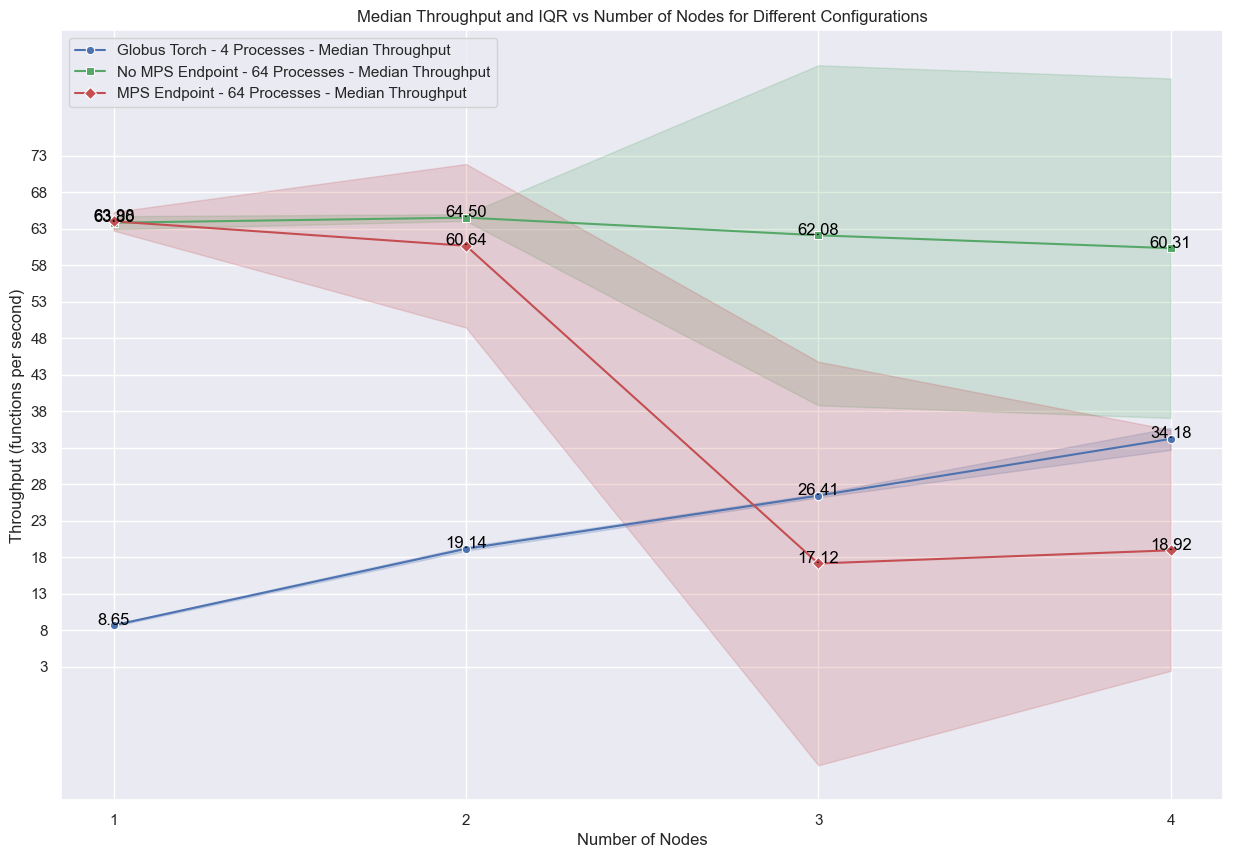

In [2]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_dict = {config: [] for config in configurations}

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
            if nodes > 4:
                continue
            throughputs = [data[key]['throughput'] for key in data]
            median_throughput = np.median(throughputs)
            q75, q25 = np.percentile(throughputs, [75, 25])
            iqr = q75 - q25
            
            data_dict[config].append({
                'Nodes': nodes,
                'Median Throughput': median_throughput,
                'IQR': iqr
            })

# Convert data_dict to DataFrames
dfs = {config: pd.DataFrame(data_list) for config, data_list in data_dict.items()}

# Sort the DataFrames by the number of nodes
for config in configurations:
    dfs[config] = dfs[config].sort_values(by='Nodes')

# Calculate the theoretical scaling line for each configuration
for config in configurations:
    initial_throughput = dfs[config][dfs[config]['Nodes'] == 1]['Median Throughput'].values[0]
    dfs[config]['Theoretical Scaling'] = dfs[config]['Nodes'] * initial_throughput

# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['b', 'g', 'r']  # Colors for different configurations
markers = ['o', 's', 'D']  # Markers for different configurations
config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}

for i, config in enumerate(configurations):
    df = dfs[config]
    color = colors[i]
    marker = markers[i]
    label = config_labels[config]

    # Plot the median throughput
    sns.lineplot(data=df, x='Nodes', y='Median Throughput', marker=marker, label=f'{label} - Median Throughput', color=color)

    # Add 
    # TODO add the min and max throughput as the bounds of the fill
    # Add violin plot for IQR 
    plt.fill_between(df['Nodes'], 
                     df['Median Throughput'] - df['IQR'] / 2, 
                     df['Median Throughput'] + df['IQR'] / 2, 
                     color=color, alpha=0.2)

    # Add labels for the markers
    for j in range(len(df)):
        plt.text(df['Nodes'].iloc[j], df['Median Throughput'].iloc[j] + 0.1, 
                 f'{df["Median Throughput"].iloc[j]:.2f}', 
                 horizontalalignment='center', color='black')

    # Plot the theoretical scaling line
    # sns.lineplot(data=df, x='Nodes', y='Theoretical Scaling', marker='x', label=f'{label} - Theoretical Scaling', color=color, linestyle='--')

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Nodes for Different Configurations')
# only include integer values for the x-axis
plt.xticks(np.arange(dfs[configurations[0]]['Nodes'].min(), dfs[configurations[0]]['Nodes'].max()+1, 1))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(min(df['Median Throughput'].min() for df in dfs.values()))-5, 
                     int(max(df['Median Throughput'].max() for df in dfs.values()))+10, 5))
plt.legend()
plt.show()


## Using the whiskerplot instead of IQR

/var/folders/jm/6n3dx9_54flc1q5_dqq2dwx40000gn/T/ipykernel_5661/2605429055.py:68: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=data, x='Nodes', y='Throughput', hue='Configuration',


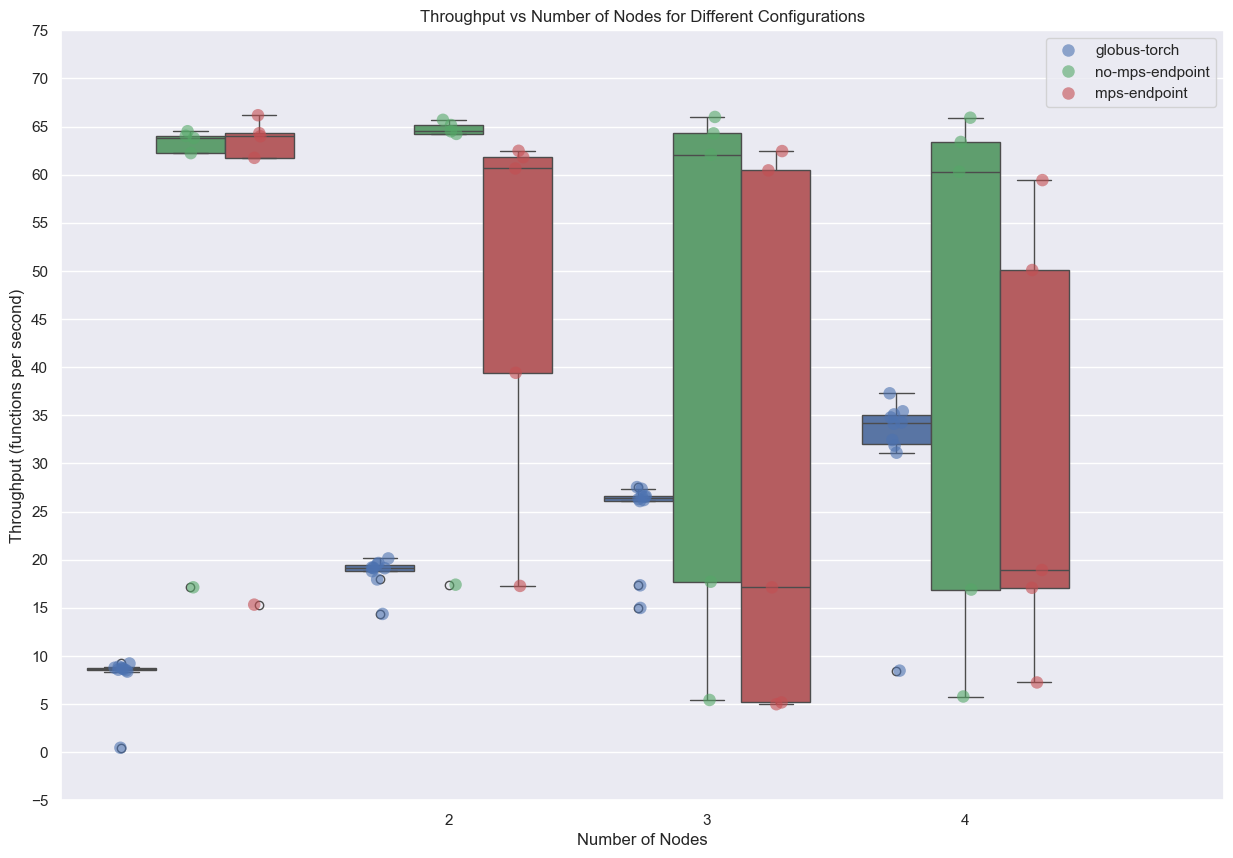

In [58]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']
# only nodes from 1 to 4
files = [file for file in files if int(file.split('_')[0]) <= 4]

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_dict = {config: [] for config in configurations}

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
       
            throughputs = [data[key]['throughput'] for key in data]
            
            for throughput in throughputs:
                data_dict[config].append({
                    'Nodes': nodes,
                    'Throughput': throughput,
                    'Configuration': config
                })

# Convert data_dict to DataFrame
data = pd.DataFrame([item for sublist in data_dict.values() for item in sublist])

# Sort the DataFrame by the number of nodes
data = data.sort_values(by=['Configuration', 'Nodes'])


# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}

# Update the hue order to match the configurations order
hue_order = configurations

# Plot the whisker plot
sns.boxplot(data=data, x='Nodes', y='Throughput', hue='Configuration', 
            palette=['b', 'g', 'r'], dodge=True, hue_order=hue_order)

# Plot the individual datapoints
sns.stripplot(data=data, x='Nodes', y='Throughput', hue='Configuration', 
              palette=['b', 'g', 'r'], size=9, jitter=True, dodge=True,
              edgecolor='gray', alpha=0.6, hue_order=hue_order)

# Add labels and title
plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Throughput vs Number of Nodes for Different Configurations')

# Set x and y ticks
plt.xticks(np.arange(data['Nodes'].min(), data['Nodes'].max()+1, 1))
plt.yticks(np.arange(int(data['Throughput'].min())-5, int(data['Throughput'].max())+10, 5))

# Update the legend to prevent duplication
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


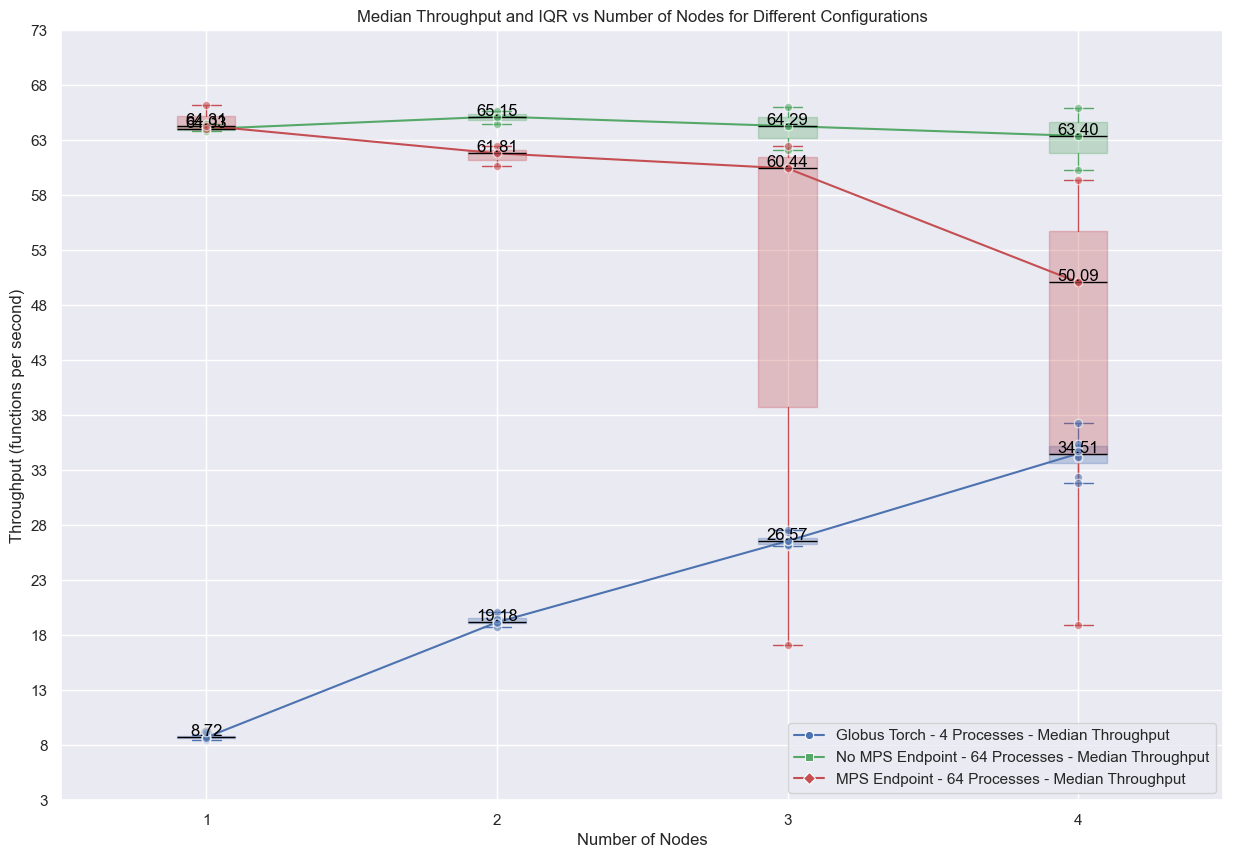

In [30]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_dict = {config: [] for config in configurations}

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
            if nodes > 4:
                continue
            throughputs = [data[key]['throughput'] for key in data]

            # Exclude the minimum values of throughput
            min_throughput = min(throughputs)
            throughputs = [tp for tp in throughputs if tp > min_throughput]
            # Exclude the minimum values of throughput
            min_throughput = min(throughputs)
            throughputs = [tp for tp in throughputs if tp > min_throughput]
            
            median_throughput = np.median(throughputs)
            q75, q25 = np.percentile(throughputs, [75, 25])
            iqr = q75 - q25
            
            data_dict[config].append({
                'Nodes': nodes,
                'Throughputs': throughputs,
                'Median Throughput': median_throughput,
                'IQR': iqr
            })

# Convert data_dict to DataFrames
dfs = {config: pd.DataFrame(data_list) for config, data_list in data_dict.items()}

# Sort the DataFrames by the number of nodes
for config in configurations:
    dfs[config] = dfs[config].sort_values(by='Nodes')

# Calculate the theoretical scaling line for each configuration
for config in configurations:
    initial_throughput = dfs[config][dfs[config]['Nodes'] == 1]['Median Throughput'].values[0]
    dfs[config]['Theoretical Scaling'] = dfs[config]['Nodes'] * initial_throughput

# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['b', 'g', 'r']  # Colors for different configurations
markers = ['o', 's', 'D']  # Markers for different configurations
config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}

for i, config in enumerate(configurations):

    df = dfs[config]
    color = colors[i]
    marker = markers[i]
    label = config_labels[config]

    # Plot the median throughput
    sns.lineplot(data=df, x='Nodes', y='Median Throughput', marker=marker, label=f'{label} - Median Throughput', color=color)

    # Add whisker plot and datapoints
    for j in range(len(df)):
        nodes = df['Nodes'].iloc[j]
        throughputs = df['Throughputs'].iloc[j]
        
        # Plot the violin plot for IQR
        plt.boxplot(throughputs, positions=[nodes], widths=0.2, patch_artist=True,
                    boxprops=dict(facecolor=color, color=color, alpha=0.3),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color=color),
                    capprops=dict(color=color),
                    flierprops=dict(marker='o', color=color, alpha=0.5))

        # Plot individual data points
        plt.scatter([nodes] * len(throughputs), throughputs, color=color, alpha=0.6, edgecolors='w', zorder=3)

    # Add labels for the markers
    for j in range(len(df)):
        plt.text(df['Nodes'].iloc[j], df['Median Throughput'].iloc[j] + 0.1, 
                 f'{df["Median Throughput"].iloc[j]:.2f}', 
                 horizontalalignment='center', color='black')

    # Plot the theoretical scaling line
    # sns.lineplot(data=df, x='Nodes', y='Theoretical Scaling', marker='x', label=f'{label} - Theoretical Scaling', color=color, linestyle='--')

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Nodes for Different Configurations')
# only include integer values for the x-axis
plt.xticks(np.arange(dfs[configurations[0]]['Nodes'].min(), dfs[configurations[0]]['Nodes'].max()+1, 1))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(min(df['Median Throughput'].min() for df in dfs.values()))-5, 
                     int(max(df['Median Throughput'].max() for df in dfs.values()))+10, 5))
plt.legend()
plt.show()


## OR

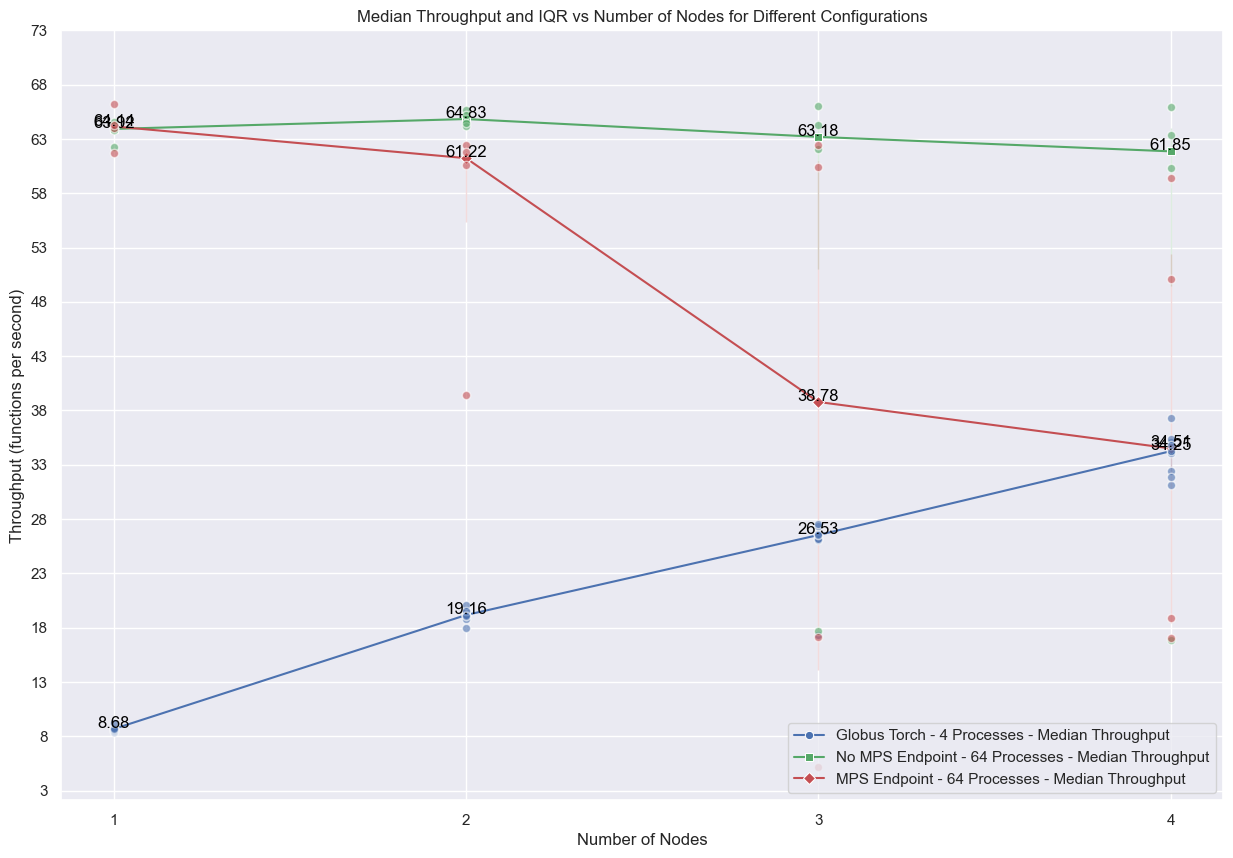

In [8]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_dict = {config: [] for config in configurations}

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
            if nodes > 4:
                continue
            throughputs = [data[key]['throughput'] for key in data]

            # Exclude the minimum values of throughput
            min_throughput = min(throughputs)
            throughputs = [tp for tp in throughputs if tp > min_throughput]
            
            median_throughput = np.median(throughputs)
            q75, q25 = np.percentile(throughputs, [75, 25])
            iqr = q75 - q25
            
            data_dict[config].append({
                'Nodes': nodes,
                'Throughputs': throughputs,
                'Median Throughput': median_throughput,
                'IQR': iqr
            })

# Convert data_dict to DataFrames
dfs = {config: pd.DataFrame(data_list) for config, data_list in data_dict.items()}

# Sort the DataFrames by the number of nodes
for config in configurations:
    dfs[config] = dfs[config].sort_values(by='Nodes')

# Calculate the theoretical scaling line for each configuration
for config in configurations:
    initial_throughput = dfs[config][dfs[config]['Nodes'] == 1]['Median Throughput'].values[0]
    dfs[config]['Theoretical Scaling'] = dfs[config]['Nodes'] * initial_throughput

# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['b', 'g', 'r']  # Colors for different configurations
markers = ['o', 's', 'D']  # Markers for different configurations
config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}

for i, config in enumerate(configurations):

    df = dfs[config]
    color = colors[i]
    marker = markers[i]
    label = config_labels[config]

    # Plot the median throughput
    sns.lineplot(data=df, x='Nodes', y='Median Throughput', marker=marker, label=f'{label} - Median Throughput', color=color)

    # Add whisker plot and datapoints
    for j in range(len(df)):
        nodes = df['Nodes'].iloc[j]
        throughputs = df['Throughputs'].iloc[j]
        
        # Plot the violin plot for IQR
        plt.fill_between([nodes], 
                         np.percentile(throughputs, 25), 
                         np.percentile(throughputs, 75), 
                         color=color, alpha=0.2)

        # Plot individual data points
        plt.scatter([nodes] * len(throughputs), throughputs, color=color, alpha=0.6, edgecolors='w', zorder=3)

    # Add labels for the markers
    for j in range(len(df)):
        plt.text(df['Nodes'].iloc[j], df['Median Throughput'].iloc[j] + 0.1, 
                 f'{df["Median Throughput"].iloc[j]:.2f}', 
                 horizontalalignment='center', color='black')

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Nodes for Different Configurations')
# only include integer values for the x-axis
plt.xticks(np.arange(dfs[configurations[0]]['Nodes'].min(), dfs[configurations[0]]['Nodes'].max()+1, 1))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(min(df['Median Throughput'].min() for df in dfs.values()))-5, 
                     int(max(df['Median Throughput'].max() for df in dfs.values()))+10, 5))
plt.legend()
plt.show()


## Using Violin Plot instead of IQR

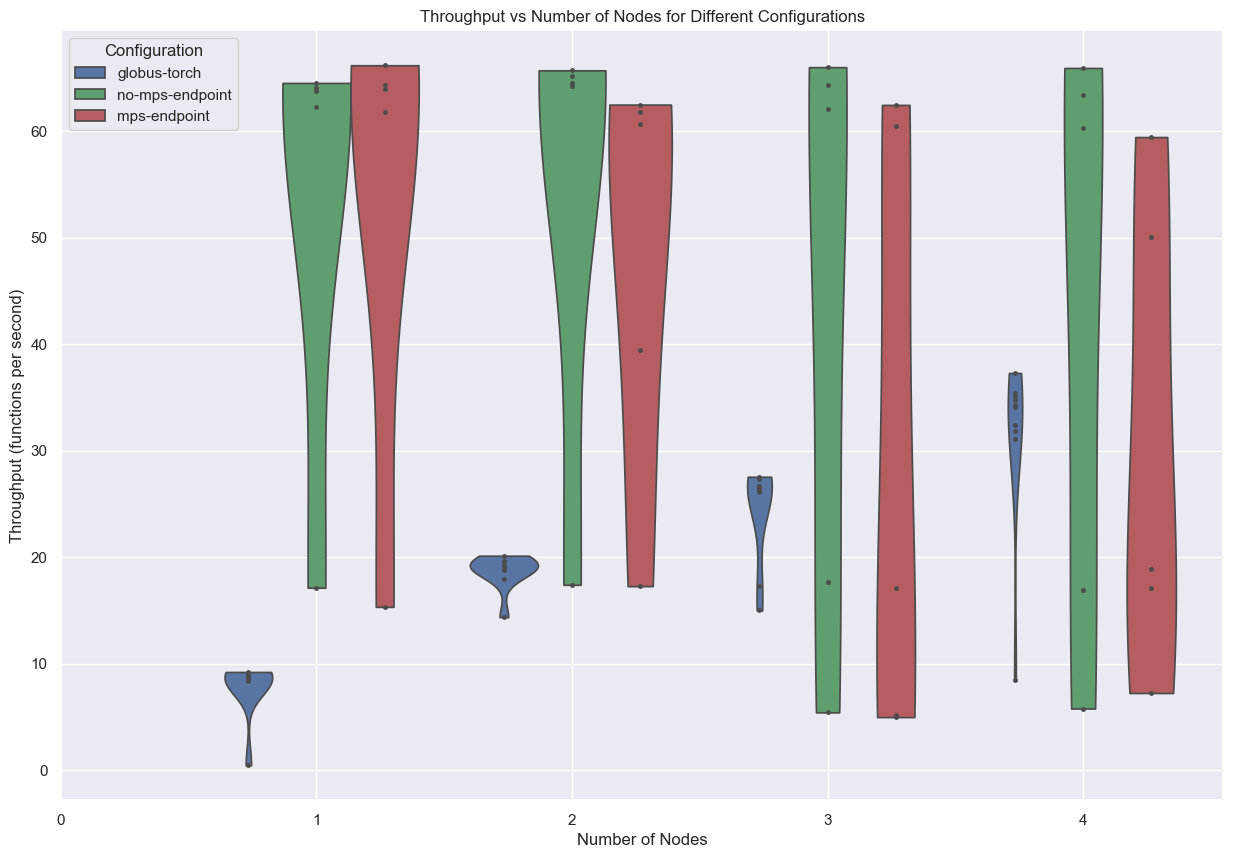

In [43]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_list = []
Means = [] 
Medians = []

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
            if nodes > 4:
                continue
            throughputs = [data[key]['throughput'] for key in data]
            # calculate the median throughput
            median_throughput = np.median(throughputs)
            Medians.append(median_throughput)
            # calculate the mean throughput
            mean_throughput = np.mean(throughputs)
            Means.append(mean_throughput)
            for throughput in throughputs:
                data_list.append({
                    'Nodes': nodes,
                    'Throughput': throughput,
                    'Median Throughput': median_throughput,
                    'Configuration': config
                })

# Convert data_list to DataFrame
df = pd.DataFrame(data_list)

# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['b', 'g', 'r']  # Colors for different configurations
config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}


# Plot the violin plot
sns.violinplot(data=df, x='Nodes', y='Throughput', hue='Configuration', palette=colors, inner='point', native_scale=True, cut=0)

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Throughput vs Number of Nodes for Different Configurations')
# only include integer values for the x-axis
plt.xticks(np.arange(df['Nodes'].min()-1, df['Nodes'].max()+1, 1))
plt.legend(title='Configuration')
plt.show()


## New try with Vioin Plots

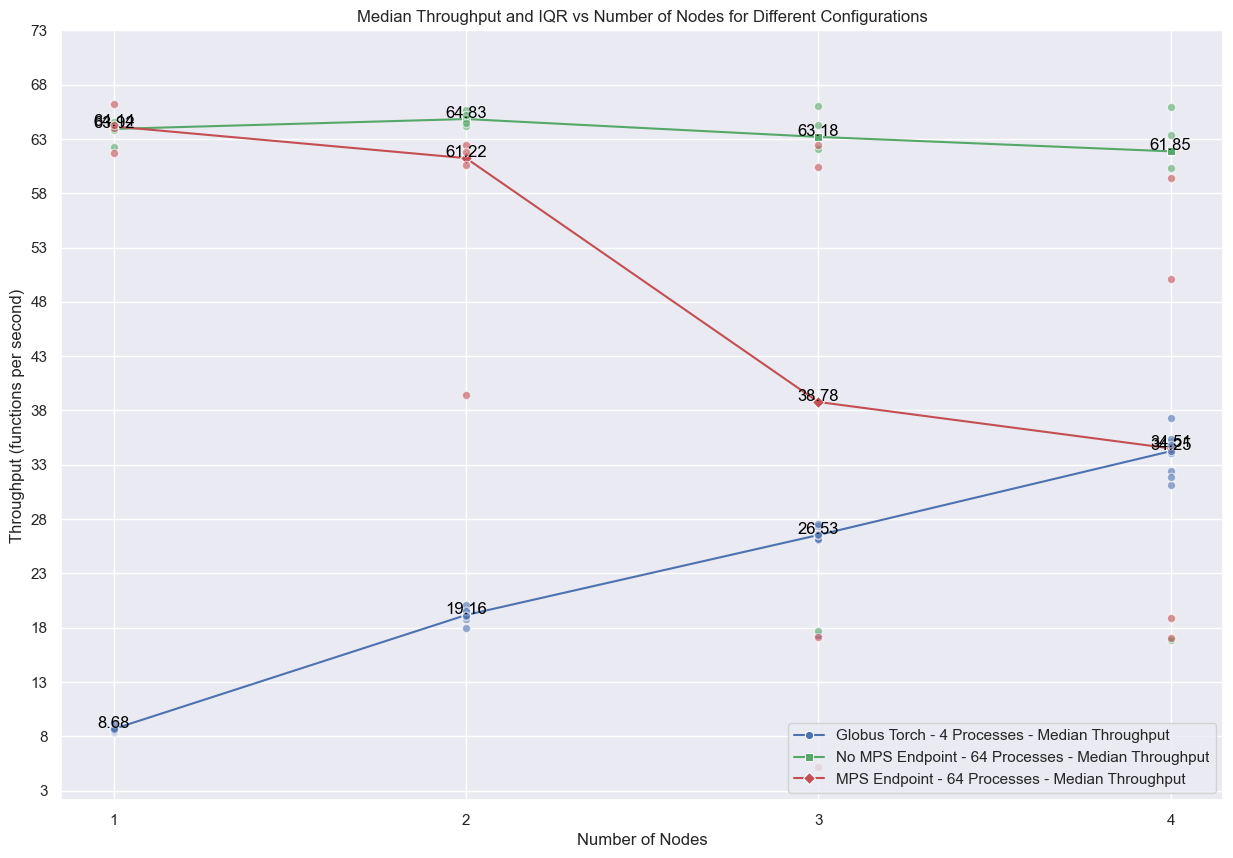

In [29]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/multi_node/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config.json where config is the configuration name
files = os.listdir(file_dir)
# only include files that have the correct format: #_node_throughput_pytorch_concurrent_1024_config.json
files = [file for file in files if file.endswith('.json') and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['globus-torch', 'no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations and number of processes
config_files = {
    'globus-torch': [file for file in files if 'globus-torch' in file],
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[-2] == '64'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[-2] == '64']
}

data_dict = {config: [] for config in configurations}

for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of nodes from the filename
            nodes = int(file.split('_')[0])
            if nodes > 4:
                continue
            throughputs = [data[key]['throughput'] for key in data]

            # Exclude the minimum values of throughput
            min_throughput = min(throughputs)
            throughputs = [tp for tp in throughputs if tp > min_throughput]
            
            median_throughput = np.median(throughputs)
            q75, q25 = np.percentile(throughputs, [75, 25])
            iqr = q75 - q25
            
            data_dict[config].append({
                'Nodes': nodes,
                'Throughputs': throughputs,
                'Median Throughput': median_throughput,
                'IQR': iqr
            })

# Convert data_dict to DataFrames
dfs = {config: pd.DataFrame(data_list) for config, data_list in data_dict.items()}

# Sort the DataFrames by the number of nodes
for config in configurations:
    dfs[config] = dfs[config].sort_values(by='Nodes')

# Calculate the theoretical scaling line for each configuration
for config in configurations:
    initial_throughput = dfs[config][dfs[config]['Nodes'] == 1]['Median Throughput'].values[0]
    dfs[config]['Theoretical Scaling'] = dfs[config]['Nodes'] * initial_throughput

# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['b', 'g', 'r']  # Colors for different configurations
markers = ['o', 's', 'D']  # Markers for different configurations
config_labels = {
    'globus-torch': 'Globus Torch - 4 Processes',
    'no-mps-endpoint': 'No MPS Endpoint - 64 Processes',
    'mps-endpoint': 'MPS Endpoint - 64 Processes'
}

for i, config in enumerate(configurations):

    df = dfs[config]
    color = colors[i]
    marker = markers[i]
    label = config_labels[config]

    # Plot the median throughput
    sns.lineplot(data=df, x='Nodes', y='Median Throughput', marker=marker, label=f'{label} - Median Throughput', color=color)

    # Add whisker plot and datapoints
    for j in range(len(df)):
        nodes = df['Nodes'].iloc[j]
        throughputs = df['Throughputs'].iloc[j]

        # Plot individual data points
        plt.scatter([nodes] * len(throughputs), throughputs, color=color, alpha=0.6, edgecolors='w', zorder=3)

    # Add labels for the markers
    for j in range(len(df)):
        plt.text(df['Nodes'].iloc[j], df['Median Throughput'].iloc[j] + 0.1, 
                 f'{df["Median Throughput"].iloc[j]:.2f}', 
                 horizontalalignment='center', color='black')

    # Plot the theoretical scaling line
    # sns.lineplot(data=df, x='Nodes', y='Theoretical Scaling', marker='x', label=f'{label} - Theoretical Scaling', color=color, linestyle='--')

plt.xlabel('Number of Nodes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Nodes for Different Configurations')
# only include integer values for the x-axis
plt.xticks(np.arange(dfs[configurations[0]]['Nodes'].min(), dfs[configurations[0]]['Nodes'].max()+1, 1))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(min(df['Median Throughput'].min() for df in dfs.values()))-5, 
                     int(max(df['Median Throughput'].max() for df in dfs.values()))+10, 5))
plt.legend()
plt.show()


## Plotting GC results comparing MPS and no-MPS across different number of accellerators/processes

no-mps-endpoint files: ['1_node_throughput_pytorch_concurrent_1024_no-mps-endpoint_4_proc.json', '1_node_throughput_pytorch_concurrent_1024_no-mps-endpoint_16_proc.json', '1_node_throughput_pytorch_concurrent_1024_no-mps-endpoint_8_proc.json', '1_node_throughput_pytorch_concurrent_1024_no-mps-endpoint_32_proc.json', '1_node_throughput_pytorch_concurrent_1024_no-mps-endpoint_64_proc.json']
mps-endpoint files: ['1_node_throughput_pytorch_concurrent_1024_mps-endpoint_16_proc.json', '1_node_throughput_pytorch_concurrent_1024_mps-endpoint_64_proc.json', '1_node_throughput_pytorch_concurrent_1024_mps-endpoint_8_proc.json', '1_node_throughput_pytorch_concurrent_1024_mps-endpoint_32_proc.json', '1_node_throughput_pytorch_concurrent_1024_mps-endpoint_4_proc.json']


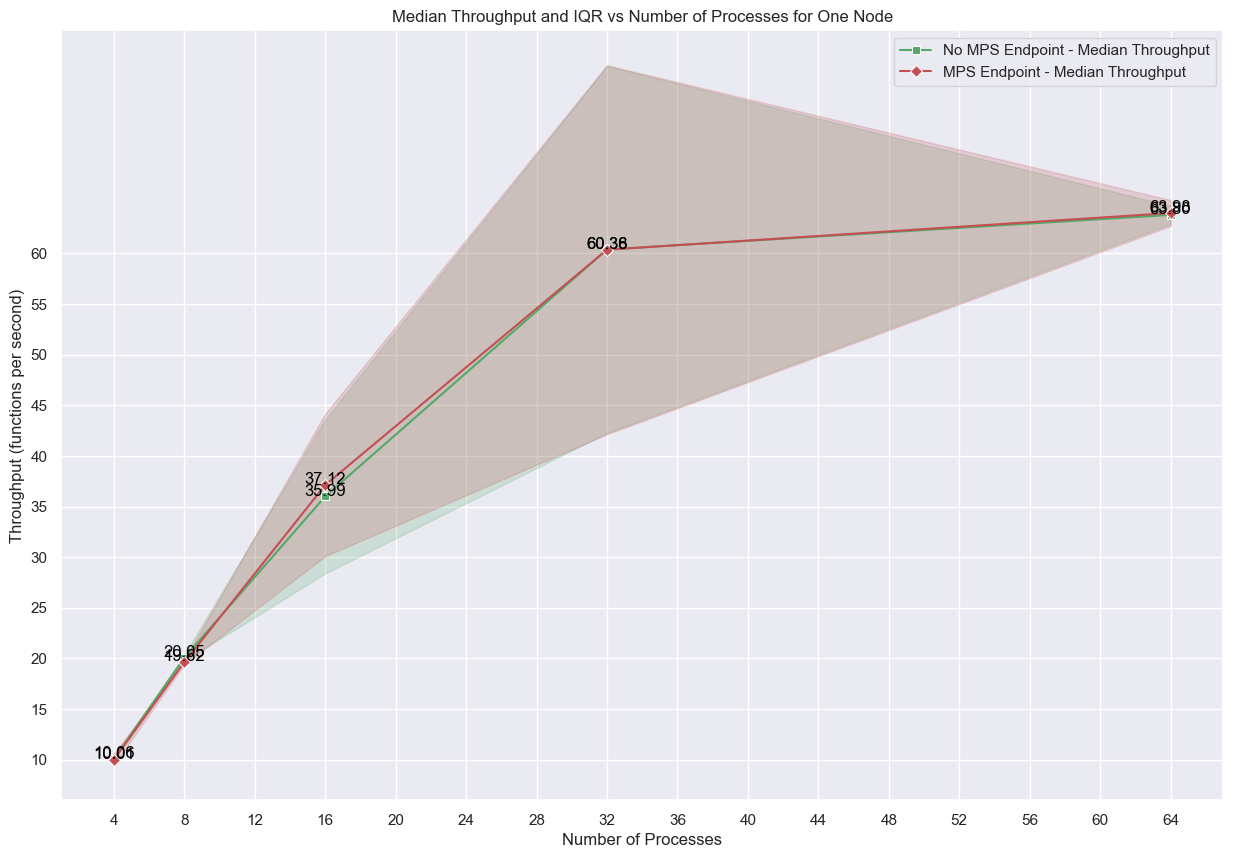

In [21]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

file_dir = "results_throughput/"
# Each file is named like #_node_throughput_pytorch_concurrent_1024_config_proc.json where config is the configuration name and proc is the number of processes
files = os.listdir(file_dir)
# only include files that have the correct format: 1_node_throughput_pytorch_concurrent_1024_config_proc.json
files = [file for file in files if file.endswith('.json') and file.split('_')[0] == '1' and file.split('_')[1] == 'node' and file.split('_')[2] == 'throughput']

configurations = ['no-mps-endpoint', 'mps-endpoint']

# Filter files based on configurations, one node, and include the number of processes
config_files = {
    'no-mps-endpoint': [file for file in files if 'no-mps-endpoint' in file and file.split('_')[0] == '1'],
    'mps-endpoint': [file for file in files if '_mps-endpoint' in file and file.split('_')[0] == '1']
}

data_dict = {config: [] for config in configurations}

print("no-mps-endpoint files:", config_files['no-mps-endpoint'])
print("mps-endpoint files:", config_files['mps-endpoint'])



for config in configurations:
    for file in config_files[config]:
        with open(os.path.join(file_dir, file), 'r') as f:
            data = json.load(f)
            # Extract the number of processes from the filename
            processes = int(file.split('_')[-2])
            throughputs = [data[key]['throughput'] for key in data]
            median_throughput = np.median(throughputs)
            q75, q25 = np.percentile(throughputs, [75, 25])
            iqr = q75 - q25
            
            data_dict[config].append({
                'Processes': processes,
                'Median Throughput': median_throughput,
                'IQR': iqr
            })

# Convert data_dict to DataFrames
dfs = {config: pd.DataFrame(data_list) for config, data_list in data_dict.items()}

# Sort the DataFrames by the number of processes
for config in configurations:
    dfs[config] = dfs[config].sort_values(by='Processes')



# Create a Seaborn plot
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")

colors = ['g', 'r']  # Colors for different configurations
markers = ['s', 'D']  # Markers for different configurations
config_labels = {
    'no-mps-endpoint': 'No MPS Endpoint',
    'mps-endpoint': 'MPS Endpoint'
}

for i, config in enumerate(configurations):

    df = dfs[config]
    color = colors[i]
    marker = markers[i]
    label = config_labels[config]

    # Plot the median throughput
    sns.lineplot(data=df, x='Processes', y='Median Throughput', marker=marker, label=f'{label} - Median Throughput', color=color)

    # Add the fill between for IQR
    plt.fill_between(df['Processes'], 
                     df['Median Throughput'] - df['IQR'] / 2, 
                     df['Median Throughput'] + df['IQR'] / 2, 
                     color=color, alpha=0.2)

    # Add labels for the markers
    for j in range(len(df)):
        plt.text(df['Processes'].iloc[j], df['Median Throughput'].iloc[j] + 0.1, 
                 f'{df["Median Throughput"].iloc[j]:.2f}', 
                 horizontalalignment='center', color='black')

plt.xlabel('Number of Processes')
plt.ylabel('Throughput (functions per second)')
plt.title('Median Throughput and IQR vs Number of Processes for One Node')
# only include integer values for the x-axis
plt.xticks(np.arange(dfs[configurations[0]]['Processes'].min(), dfs[configurations[0]]['Processes'].max()+1, 4))
# y values should be ticks of integers starting from the minimum value of the median throughput to the maximum value of the median throughput
plt.yticks(np.arange(int(min(df['Median Throughput'].min() for df in dfs.values())), 
                     int(max(df['Median Throughput'].max() for df in dfs.values()))+1, 5))
plt.legend()
plt.show()
